In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 불러오기
df = pd.read_csv('data/Churn_Modelling.csv')

# 분석/상관관계 등에서 불필요한 컬럼 제거
drop_cols = ['RowNumber', 'CustomerId', 'Surname']
df_use = df.drop(columns=drop_cols)

# 상위 5개 행 확인
print(df.head())

# 데이터 크기(행, 열)
print(df.shape)

# 컬럼별 데이터 타입 및 결측치 확인
print(df.info())

# 기초 통계량 확인
print(df.describe())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [3]:
# 결측치 확인
print(df.isnull().sum())

# 중복 데이터 확인
print(df.duplicated().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
0


Exited
0    7963
1    2037
Name: count, dtype: int64
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


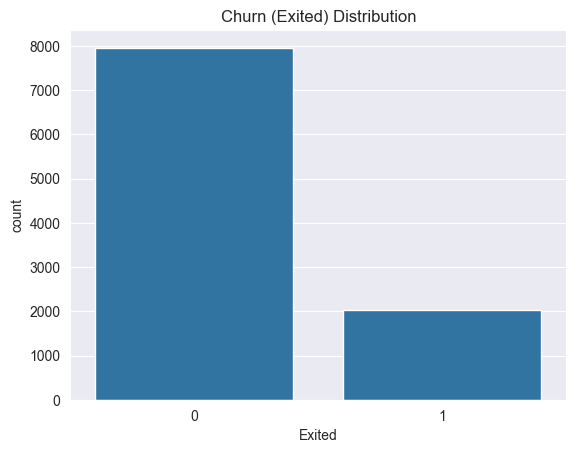

In [4]:
# 이탈 여부 분포
print(df['Exited'].value_counts())
print(df['Exited'].value_counts(normalize=True))

sns.countplot(x='Exited', data=df)
plt.title('Churn (Exited) Distribution')
plt.show()


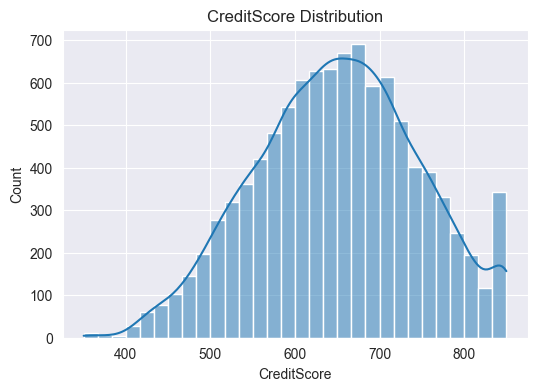

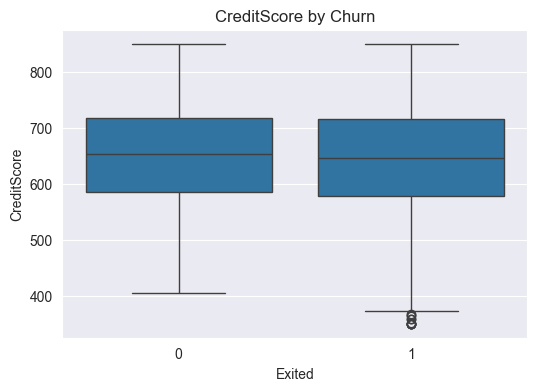

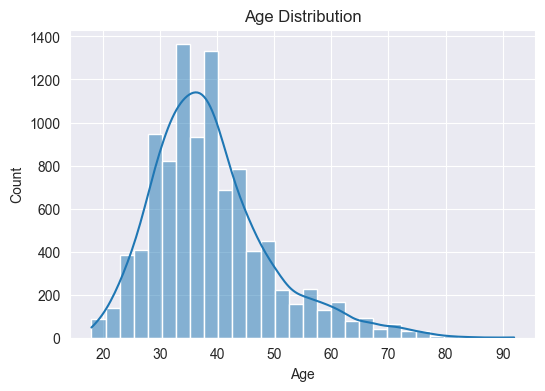

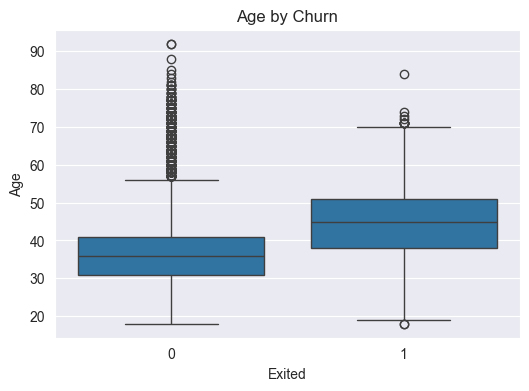

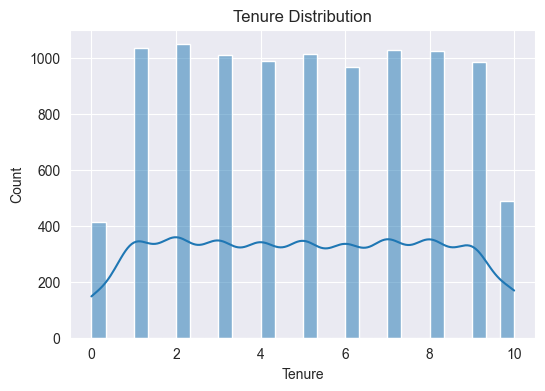

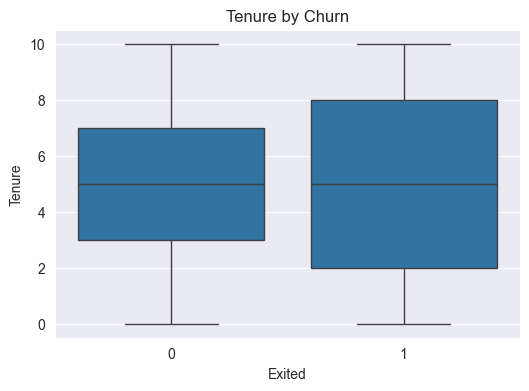

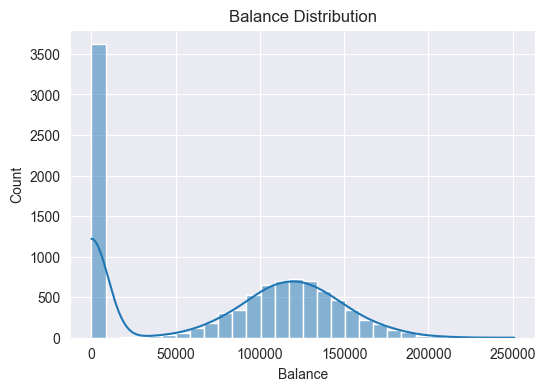

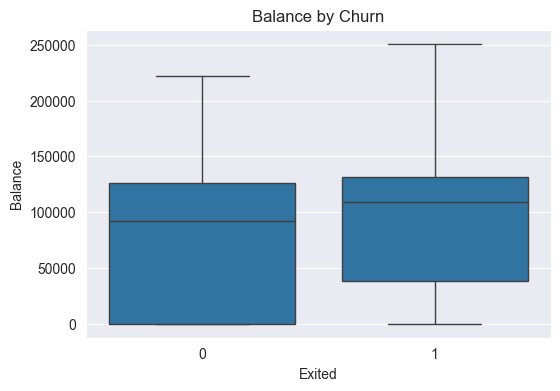

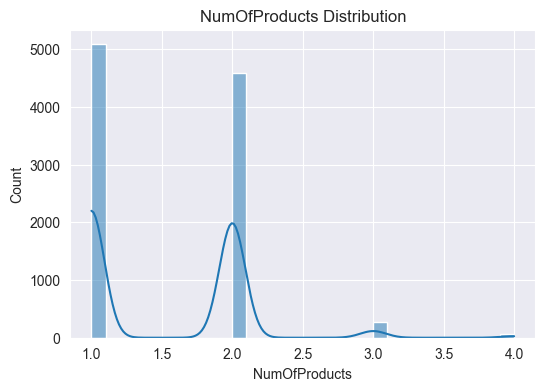

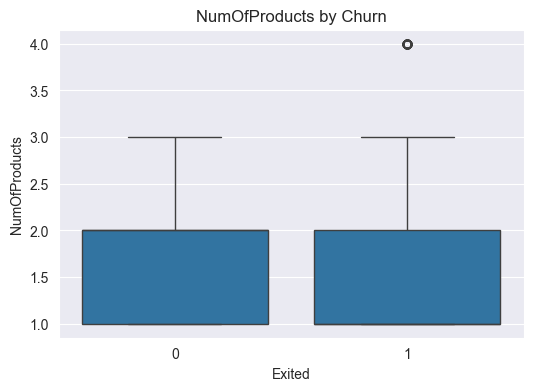

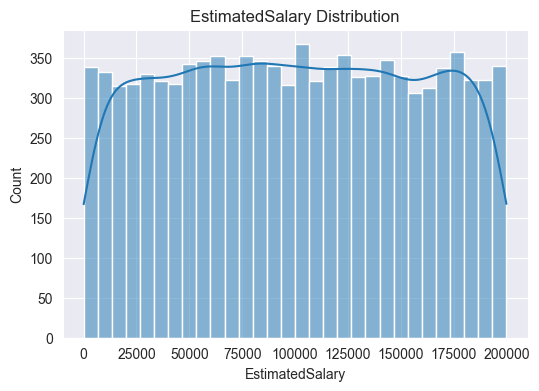

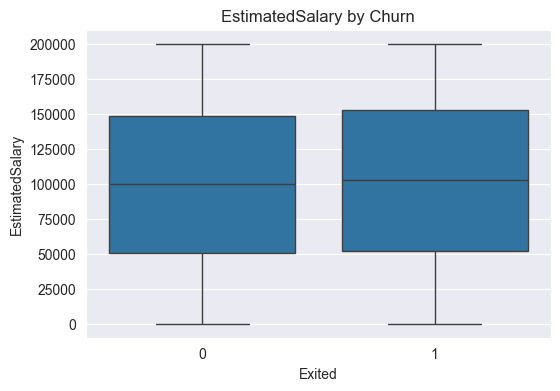

In [5]:
# 수치형 변수 리스트
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Distribution')
    plt.show()

    # 이탈 여부별 분포
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Exited', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.show()


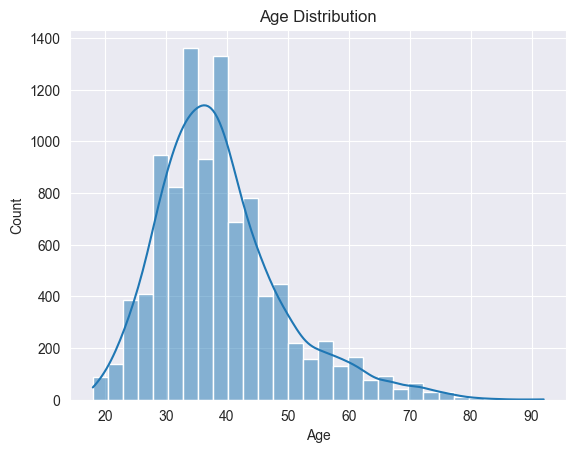

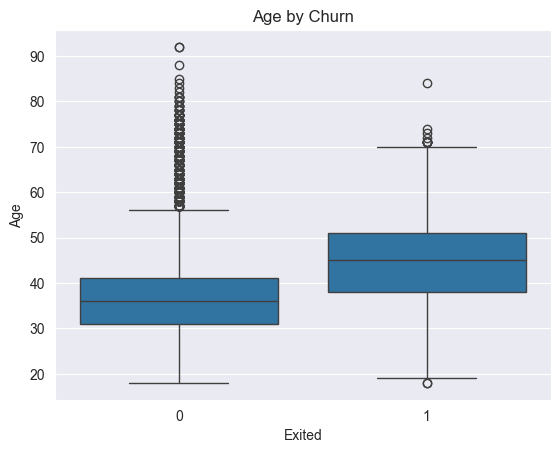

In [6]:
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

sns.boxplot(x='Exited', y='Age', data=df)
plt.title('Age by Churn')
plt.show()


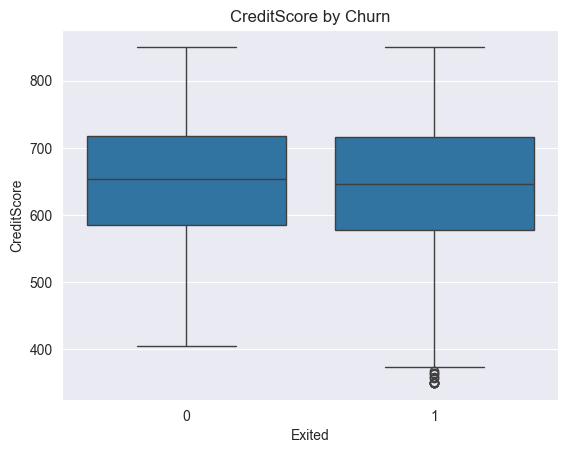

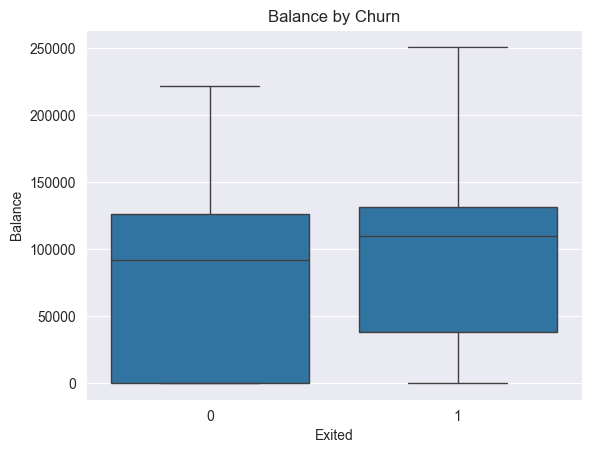

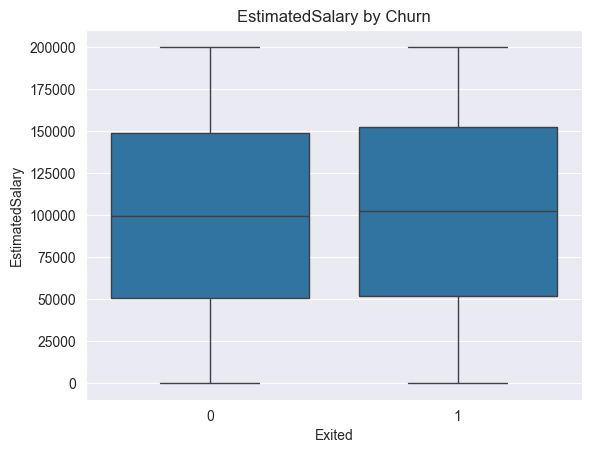

In [7]:
num_cols = ['CreditScore', 'Balance', 'EstimatedSalary']
for col in num_cols:
    sns.boxplot(x='Exited', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.show()


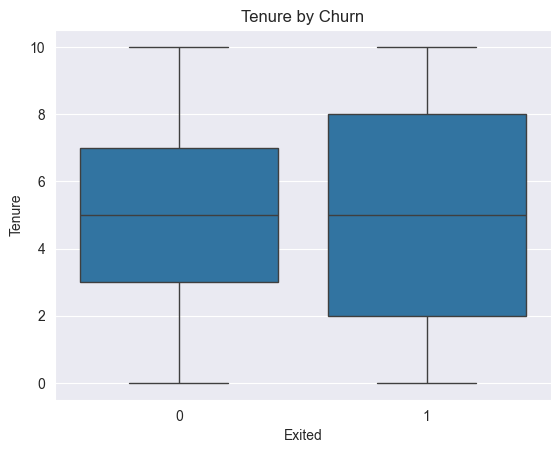

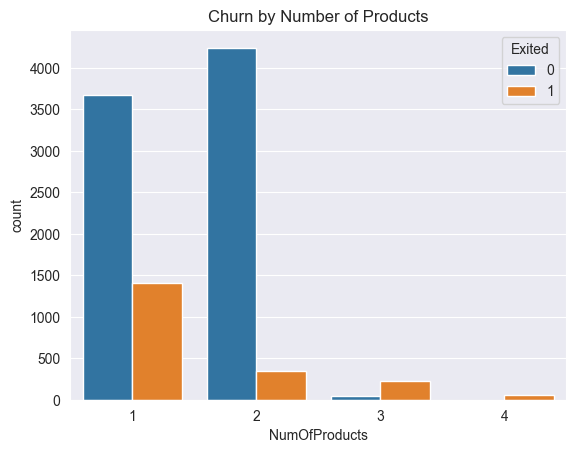

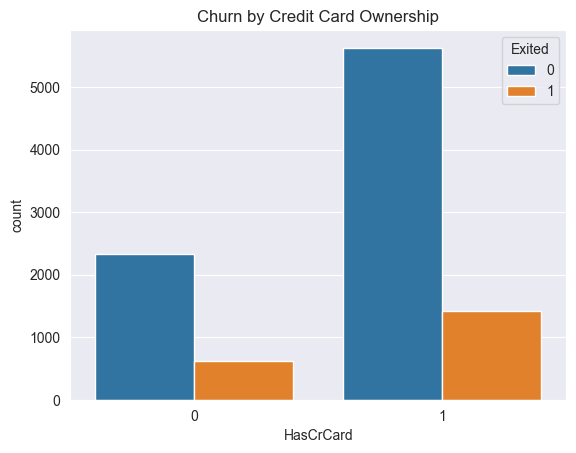

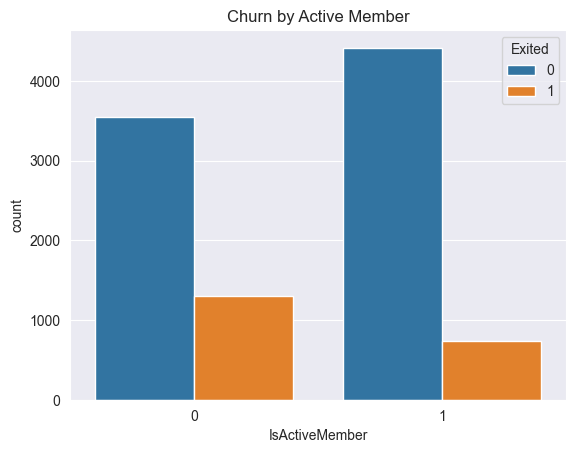

In [8]:
sns.boxplot(x='Exited', y='Tenure', data=df)
plt.title('Tenure by Churn')
plt.show()

sns.countplot(x='NumOfProducts', hue='Exited', data=df)
plt.title('Churn by Number of Products')
plt.show()

sns.countplot(x='HasCrCard', hue='Exited', data=df)
plt.title('Churn by Credit Card Ownership')
plt.show()

sns.countplot(x='IsActiveMember', hue='Exited', data=df)
plt.title('Churn by Active Member')
plt.show()


Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64


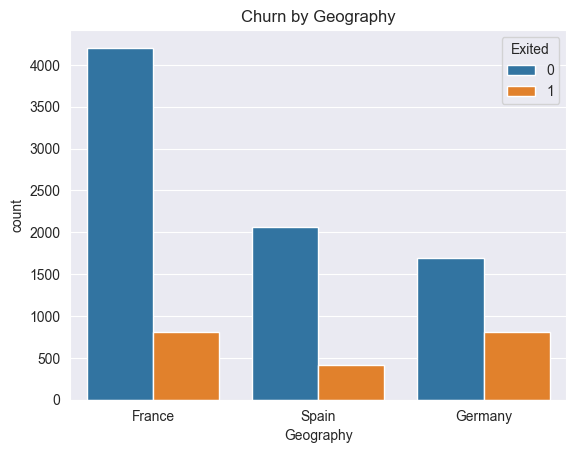

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
Name: Exited, dtype: float64


In [9]:
print(df['Geography'].value_counts())
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Churn by Geography')
plt.show()

# 지역별 이탈률
print(df.groupby('Geography')['Exited'].mean())


Gender
Male      5457
Female    4543
Name: count, dtype: int64


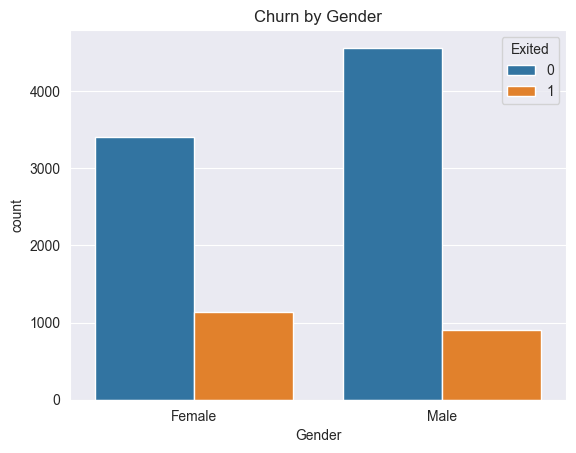

Gender
Female    0.250715
Male      0.164559
Name: Exited, dtype: float64


In [10]:
print(df['Gender'].value_counts())
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title('Churn by Gender')
plt.show()

# 성별 이탈률
print(df.groupby('Gender')['Exited'].mean())


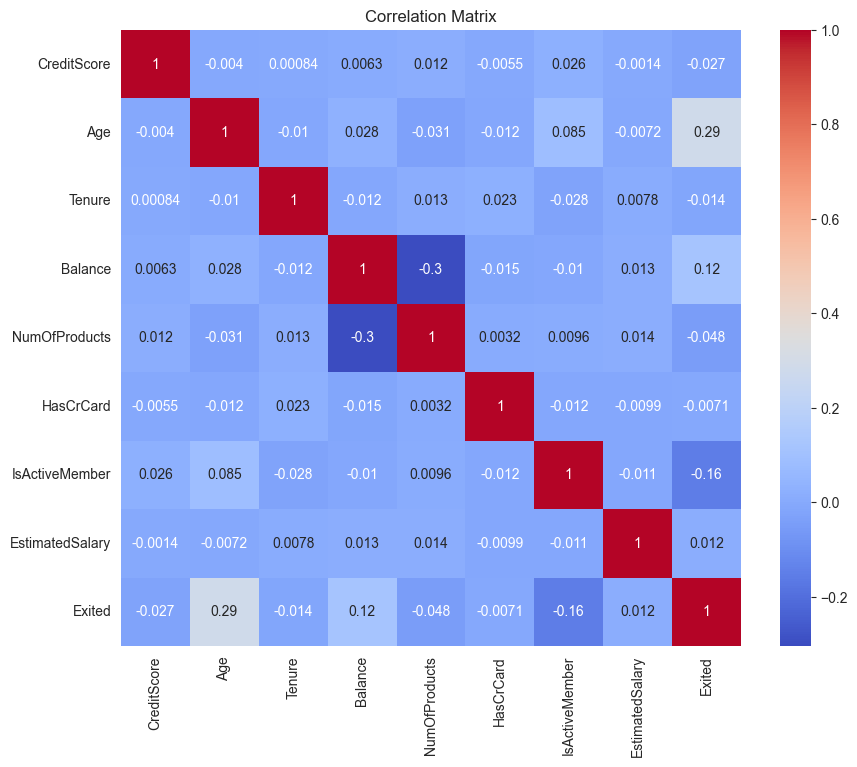

In [11]:
# 수치형 컬럼만 선택
num_cols = df_use.select_dtypes(include=['int64', 'float64']).columns
corr = df_use[num_cols].corr()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# 데이터 불러오기
df = pd.read_csv('data/Churn_Modelling.csv')

# 불필요한 컬럼 제거
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# 타겟과 피처 분리
X = df.drop('Exited', axis=1)
y = df['Exited']

# 범주형 변수 인코딩 (LightGBM은 LabelEncoder, CatBoost는 인덱스 지정)
from sklearn.preprocessing import LabelEncoder
X_enc = X.copy()
for col in ['Geography', 'Gender']:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col])

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42, stratify=y)

results = {}

In [17]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

# 1차: RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 100)
}
lgb_model = lgb.LGBMClassifier(random_state=42)
random_search = RandomizedSearchCV(
    lgb_model, param_distributions=param_dist, n_iter=30, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)
print("LightGBM 1차 Best Params:", random_search.best_params_)

# 2차: GridSearchCV (1차 결과 기반)
best_params = random_search.best_params_
param_grid = {
    'n_estimators': [best_params['n_estimators']-50, best_params['n_estimators'], best_params['n_estimators']+50],
    'max_depth': [best_params['max_depth']-1, best_params['max_depth'], best_params['max_depth']+1],
    'learning_rate': [best_params['learning_rate']*0.8, best_params['learning_rate'], best_params['learning_rate']*1.2],
    'num_leaves': [best_params['num_leaves']-10, best_params['num_leaves'], best_params['num_leaves']+10]
}
grid_search = GridSearchCV(
    lgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("LightGBM 최종 Best Params:", grid_search.best_params_)


[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [18]:
from catboost import CatBoostClassifier

# CatBoost는 범주형 변수 인덱스만 지정하면 인코딩 필요 없음
cat_features = [X.columns.get_loc('Geography'), X.columns.get_loc('Gender')]

# 1차: RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

cat_model = CatBoostClassifier(verbose=0, random_seed=42)
param_dist_cat = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(1, 10)
}
random_search_cat = RandomizedSearchCV(
    cat_model, param_distributions=param_dist_cat, n_iter=20, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1
)
random_search_cat.fit(X_train, y_train, cat_features=cat_features)
print("CatBoost 1차 Best Params:", random_search_cat.best_params_)

# 2차: GridSearchCV (1차 결과 기반)
best_params_cat = random_search_cat.best_params_
param_grid_cat = {
    'iterations': [best_params_cat['iterations']-100, best_params_cat['iterations'], best_params_cat['iterations']+100],
    'learning_rate': [best_params_cat['learning_rate']*0.8, best_params_cat['learning_rate'], best_params_cat['learning_rate']*1.2],
    'depth': [best_params_cat['depth']-1, best_params_cat['depth'], best_params_cat['depth']+1],
    'l2_leaf_reg': [best_params_cat['l2_leaf_reg']*0.8, best_params_cat['l2_leaf_reg'], best_params_cat['l2_leaf_reg']*1.2]
}
grid_search_cat = GridSearchCV(
    cat_model, param_grid=param_grid_cat, cv=3, scoring='roc_auc', n_jobs=-1
)
grid_search_cat.fit(X_train, y_train, cat_features=cat_features)
print("CatBoost 최종 Best Params:", grid_search_cat.best_params_)


CatBoost 1차 Best Params: {'depth': 4, 'iterations': 559, 'l2_leaf_reg': np.float64(7.116531604882809), 'learning_rate': np.float64(0.011413261043943482)}
CatBoost 최종 Best Params: {'depth': 5, 'iterations': 659, 'l2_leaf_reg': np.float64(5.693225283906248), 'learning_rate': np.float64(0.013695913252732178)}


In [19]:
from sklearn.metrics import classification_report, roc_auc_score

# LightGBM 최적 모델
lgb_best = grid_search.best_estimator_
y_pred_lgb = lgb_best.predict(X_test)
y_proba_lgb = lgb_best.predict_proba(X_test)[:,1]
print("LightGBM Classification Report:\n", classification_report(y_test, y_pred_lgb))
print("LightGBM ROC AUC:", roc_auc_score(y_test, y_proba_lgb))

# CatBoost 최적 모델
cat_best = grid_search_cat.best_estimator_
y_pred_cat = cat_best.predict(X_test)
y_proba_cat = cat_best.predict_proba(X_test)[:,1]
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_cat))
print("CatBoost ROC AUC:", roc_auc_score(y_test, y_proba_cat))


LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000

LightGBM ROC AUC: 0.8656499334465436
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000

CatBoost ROC AUC: 0.8761427066511812


In [20]:
from sklearn.metrics import confusion_matrix
print("LightGBM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))
print("CatBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))

LightGBM Confusion Matrix:
 [[1541   52]
 [ 220  187]]
CatBoost Confusion Matrix:
 [[1543   50]
 [ 212  195]]


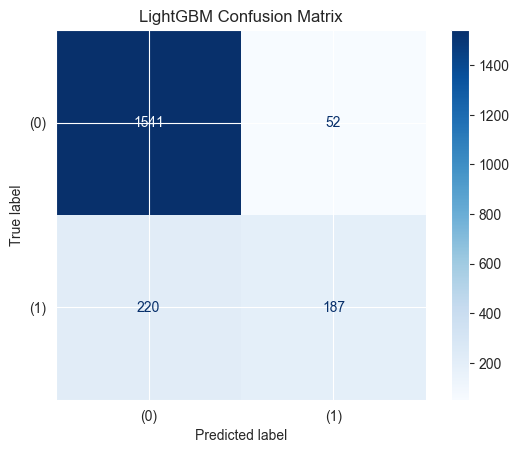

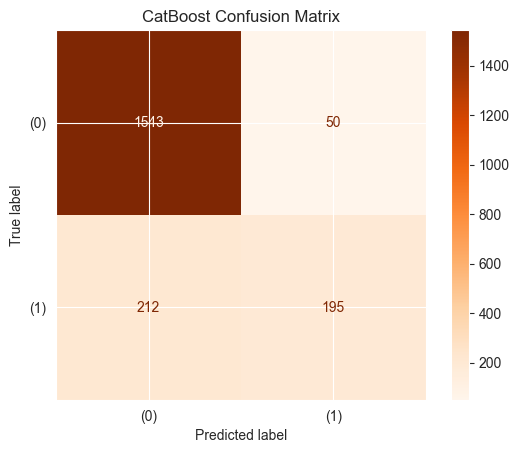

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=["(0)", "(1)"])
disp_lgb.plot(cmap='Blues')
plt.title("LightGBM Confusion Matrix")
plt.show()

# CatBoost
cm_cat = confusion_matrix(y_test, y_pred_cat)
disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=["(0)", "(1)"])
disp_cat.plot(cmap='Oranges')
plt.title("CatBoost Confusion Matrix")
plt.show()


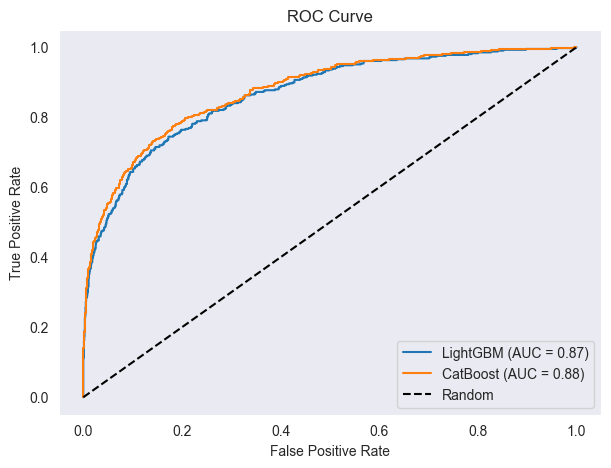

In [23]:
from sklearn.metrics import roc_curve, auc

# LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(7,5))
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {roc_auc_cat:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


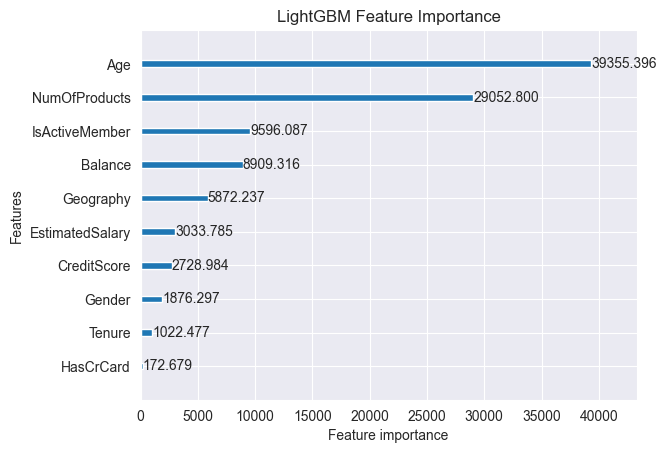

In [24]:
import lightgbm as lgb
lgb.plot_importance(lgb_best, max_num_features=10, importance_type='gain')
plt.title('LightGBM Feature Importance')
plt.show()


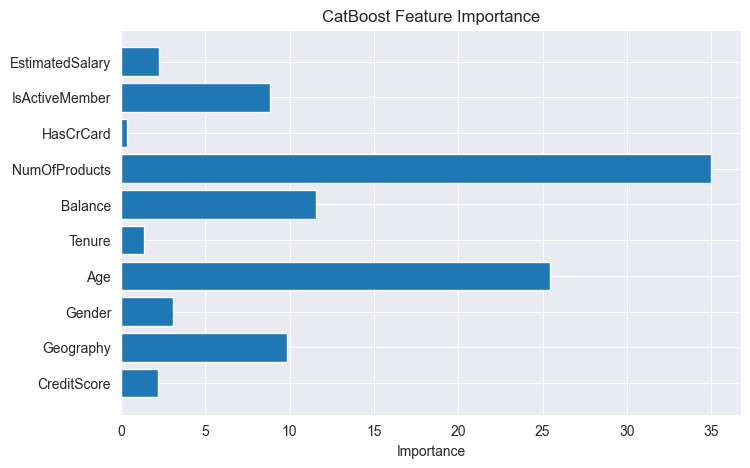

In [25]:
importances = cat_best.get_feature_importance()
features = X_test.columns
plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.show()


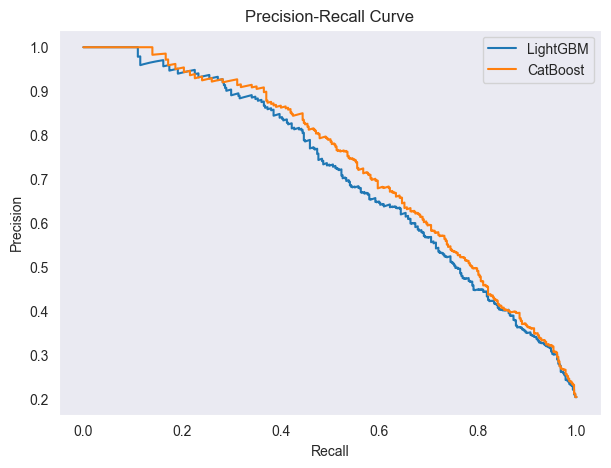

In [26]:
from sklearn.metrics import precision_recall_curve

precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_proba_lgb)
precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_proba_cat)

plt.figure(figsize=(7,5))
plt.plot(recall_lgb, precision_lgb, label='LightGBM')
plt.plot(recall_cat, precision_cat, label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()
